## Financial Planning

In [14]:
# Initial Imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

In [15]:
# Load .env environment variables
load_dotenv()

# Set Alpaca API key and secret key
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Part 1 - Personal Finance Planner

**Collect crypto prices using the `requests` library**

In [16]:
# Set current amount of crypto assets
BTC_assets = 1.2
ETH_assets = 5.3

In [17]:
#Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [18]:
# Fetch current BTC price
current_btc_price_req = requests.get(btc_url).json()
#print(json.dumps(current_btc_price_req, indent = 4)) 
current_btc_price = current_btc_price_req["data"]["1"]["quotes"]["USD"]["price"]
#print(current_btc_price)  

# Fetch current ETH price
current_eth_price_req = requests.get(eth_url).json()
#print(json.dumps(current_eth_price_req, indent = 4)). 
current_eth_price = current_eth_price_req["data"]["1027"]["quotes"]["USD"]["price"]
#print(current_eth_price).

# Compute current value of crypto assets
current_btc_value = BTC_assets * current_btc_price
current_eth_value = ETH_assets * current_eth_price

# Print current crypto wallet balance
print(f"The current value of your {BTC_assets} BTH is ${current_btc_value:0.2f}")
print(f"The current value of your {ETH_assets} ETH is ${current_eth_value:0.2f}")

The current value of your 1.2 BTH is $13671.48
The current value of your 5.3 ETH is $2001.17


** Collect Investments data using Alpaca: `SPY` (stocks) and `AGG` (bonds)**

In [19]:
# Current amount of shares
spy_shares = 50
agg_shares = 200

In [20]:
# Format current date as ISO format
current_date = pd.Timestamp("now", tz = "America/New_York").isoformat()

# Set tickers
tickers = ["AGG", "SPY"]

# Set timeframe to 1 day for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = current_date,
    end = current_date
).df

agg_close = ticker_data["AGG"]["close"]["2020-10-14"]
spy_close = ticker_data["SPY"]["close"]["2020-10-14"]

# Print AGG and SPY close price
print(f"Current AGG closing price: ${agg_close}")
print(f"Current SPY closing price: ${spy_close}")

Current AGG closing price: $118.04
Current SPY closing price: $347.97


In [21]:
# Compute the current value of shares
current_spy_value = spy_shares * spy_close
current_agg_value = agg_shares * agg_close

# Print current value of shares
print(f"The current value of your {spy_shares} SPY shares is ${current_spy_value:0.2f}")
print(f"The current value of your {agg_shares} AGG shares is ${current_agg_value:0.2f}")

The current value of your 50 SPY shares is $17398.50
The current value of your 200 AGG shares is $23608.00


** Savings Health Analysis **

In [22]:
# Set monthly household income
monthly_house_income = 12000

# Create savings dataframe
crypto_savings = current_btc_value + current_eth_value
shares_savings = current_agg_value + current_spy_value

savings_df = {
    "Amount":{
        "crypto": crypto_savings,
        "shares": shares_savings
    }
}

savings_df = pd.DataFrame(savings_df)
savings_df

Amount
crypto  15672.654
shares  41006.500

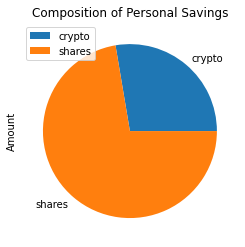

In [23]:
# Plot savings pie chart
savings_df.plot(kind = "pie", y = "Amount", title = "Composition of Personal Savings")

In [24]:
# Set ideal emrgency fund
emergency_fund = monthly_house_income * 3

# Calculate total amount of savings
total_savings = crypto_savings + shares_savings

# Validate saving health
if total_savings >= emergency_fund:
    print("Congratulations! You have enough money in your emergency fund")
else:
    print("You need to save $" + str(emergency_fund - total_savings) + " more")

Congratulations! You have enough money in your emergency fund


## Retirement Planning

** Monte Carlo Simulation **

In [33]:
# Set start and end dates of five years back from today
start_date = pd.Timestamp("2019-10-14", tz = "America/New_York").isoformat()
end_date = pd.Timestamp("2020-10-14", tz = "America/New_York").isoformat()

In [34]:
# Get 5 years' worth of historical data for SPY and AGG
stock_data_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Display sample data
stock_data_df.head()

AGG                                        SPY  \
                             open      high     low   close   volume    open   
2019-10-14 00:00:00-04:00  112.90  112.9300  112.82  112.91  1442540  295.93   
2019-10-15 00:00:00-04:00  112.90  112.9200  112.56  112.57  2799788  297.10   
2019-10-16 00:00:00-04:00  112.68  112.7900  112.62  112.72  2257665  298.37   
2019-10-17 00:00:00-04:00  112.67  112.8649  112.62  112.72  1993974  299.68   
2019-10-18 00:00:00-04:00  112.76  112.9090  112.73  112.79  1391324  298.69   

                                                               
                              high      low   close    volume  
2019-10-14 00:00:00-04:00  296.670  295.570  296.01  32589599  
2019-10-15 00:00:00-04:00  299.700  296.970  298.90  41122730  
2019-10-16 00:00:00-04:00  299.160  297.920  298.41  40765372  
2019-10-17 00:00:00-04:00  300.240  298.515  299.24  41222618  
2019-10-18 00:00:00-04:00  299.395  296.990  297.98  51564833

In [43]:
# Configure a Monte Carlo simulation to forcast 30 years cumulative returns
num_sims = 500
MC_stocks = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [0.4, 0.6],
    num_simulation = num_sims,
    num_trading_days = 252 * 30
)

In [44]:
# Print the simulation input data
MC_stocks.portfolio_data.head()

AGG                                     \
                             open      high     low   close   volume   
2019-10-14 00:00:00-04:00  112.90  112.9300  112.82  112.91  1442540   
2019-10-15 00:00:00-04:00  112.90  112.9200  112.56  112.57  2799788   
2019-10-16 00:00:00-04:00  112.68  112.7900  112.62  112.72  2257665   
2019-10-17 00:00:00-04:00  112.67  112.8649  112.62  112.72  1993974   
2019-10-18 00:00:00-04:00  112.76  112.9090  112.73  112.79  1391324   

                                           SPY                            \
                          daily_return    open     high      low   close   
2019-10-14 00:00:00-04:00          NaN  295.93  296.670  295.570  296.01   
2019-10-15 00:00:00-04:00    -0.003011  297.10  299.700  296.970  298.90   
2019-10-16 00:00:00-04:00     0.001333  298.37  299.160  297.920  298.41   
2019-10-17 00:00:00-04:00     0.000000  299.68  300.240  298.515  299.24   
2019-10-18 00:00:00-04:00     0.000621  298.69  299.395  296.990  297.98   

                                                  
                             volume daily_return  
2019-10-14 00:00:00-04:00  32589599          NaN  
2019-10-15 00:00:00-04:00  41122730     0.009763  
2019-10-16 00:00:00-04:00  40765372    -0.001639  
2019-10-17 00:00:00-04:00  41222618     0.002781  
2019-10-18 00:00:00-04:00  51564833    -0.004211

In [45]:
# Run the Monte Carlo simulation to forcast 30 years cumulative returns
MC_stocks.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1          2         3           4          5    \
0      1.000000   1.000000   1.000000  1.000000    1.000000   1.000000   
1      0.983764   0.996040   0.999370  1.002615    1.011332   0.986314   
2      0.964501   1.003420   0.997654  1.014131    0.999520   0.989172   
3      0.959138   1.035567   1.015038  1.002461    1.005015   0.970946   
4      0.976621   1.008435   1.006041  0.994442    1.016529   0.965768   
...         ...        ...        ...       ...         ...        ...   
7556  15.267541  75.244653  13.106268  7.328221  563.148556  12.043732   
7557  15.420242  73.611295  12.990475  7.203838  559.316360  11.948467   
7558  15.352468  75.040342  13.234698  7.245360  556.641272  11.965800   
7559  15.499824  75.079676  13.064150  7.197199  554.958281  11.853454   
7560  15.638860  74.032910  13.208082  7.187962  561.458752  11.623701   

            6         7          8         9    ...         490         491  \
0      1.000000  1.000000   1.000000  1.000000  ...    1.000000    1.000000   
1      1.001959  1.003186   1.007090  0.997627  ...    0.991891    0.995501   
2      1.013570  1.011906   1.023234  1.002019  ...    0.981621    0.981150   
3      1.023769  1.025430   1.064440  1.009893  ...    0.947308    0.989262   
4      1.029153  1.030371   1.063032  1.018099  ...    0.924241    1.009496   
...         ...       ...        ...       ...  ...         ...         ...   
7556  73.932515  6.995626  20.954441  2.987367  ...  427.054521  194.138475   
7557  73.005217  6.835813  20.694606  2.959223  ...  426.824700  192.991340   
7558  73.900287  6.751500  20.817414  2.955960  ...  428.065396  192.319549   
7559  74.159527  6.724137  20.731070  2.920770  ...  430.388069  189.398376   
7560  73.638676  6.884849  20.681393  2.918299  ...  430.534665  191.175814   

             492       493         494        495        496         497  \
0       1.000000  1.000000    1.000000   1.000000   1.000000    1.000000   
1       0.989197  0.989756    1.000381   0.977371   1.000452    1.007482   
2       0.957902  0.983248    1.003659   0.960729   1.013679    0.999865   
3       0.967995  0.973900    1.008468   0.946069   1.024007    1.002650   
4       0.985964  0.965999    1.032797   0.936616   1.010571    1.006581   
...          ...       ...         ...        ...        ...         ...   
7556  180.462246  3.332164  109.037459  56.356872  79.921384  428.473626   
7557  178.844388  3.355615  109.582087  56.907234  80.776502  432.721758   
7558  178.359889  3.306606  109.496072  56.007338  83.378149  438.248060   
7559  179.669787  3.254530  111.750553  58.765644  83.690581  440.331469   
7560  181.791077  3.276007  111.667899  58.897531  85.232315  437.182150   

           498        499  
0     1.000000   1.000000  
1     0.990933   0.999272  
2     0.997251   1.002894  
3     0.986806   1.004891  
4     1.002964   1.006605  
...        ...        ...  
7556  6.854852  27.962132  
7557  6.645891  27.762756  
7558  6.550060  27.727323  
7559  6.541631  27.790901  
7560  6.513098  27.855800  

[7561 rows x 500 columns]

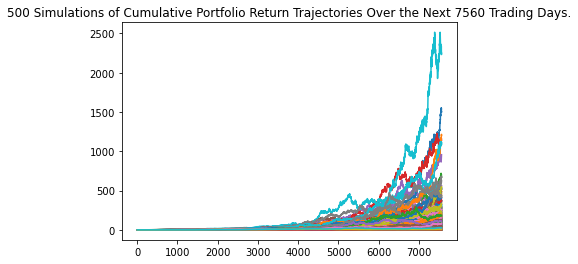

In [46]:
# Plot simulation outcomes
MC_stocks.plot_simulation()

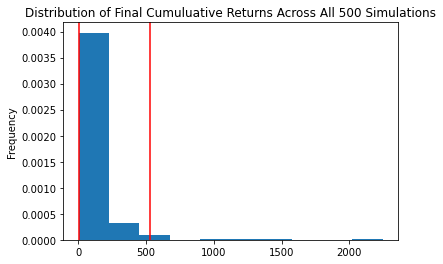

In [47]:
MC_stocks.plot_distribution()

### Retirement Analysis

In [50]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_stocks_summary = MC_stocks.summarize_cumulative_return()

# Print summary statistics
print(MC_stocks_summary)

count            500.000000
mean             102.398362
std              181.557253
min                0.839388
25%               23.490226
50%               49.092078
75%              105.100494
max             2248.501456
95% CI Lower       6.162286
95% CI Upper     525.996526
Name: 7560, dtype: float64


** Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment. **

In [53]:
# Set initial investment
initial_invest = 20000

# Use the lower and upper '95%' confidence interval to calculate the range of the possible outcomes of our $20,000
CI_lower = round(MC_stocks_summary[8] * initial_invest, 2)
CI_upper = round(MC_stocks_summary[9] * initial_invest, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_invest} in the portfolio"
      f" over the next 30 years will end within the range of"
      f" ${CI_lower} and ${CI_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within the range of $123245.72 and $10519930.53


** Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment. **

In [54]:
# Set initial investment
initial_invest_2 = initial_invest * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30000
CI_lower_2 = round(MC_stocks_summary[8] * initial_invest_2, 2)
CI_upper_2 = round(MC_stocks_summary[9] * initial_invest_2, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_invest_2} in the portfolio"
      f" over the next 30 years will end within the range of"
      f" ${CI_lower_2} and ${CI_upper_2}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within the range of $184868.57 and $15779895.79
